In [42]:
import os
import shutil
from collections import OrderedDict
import glob

import json
import matplotlib.pyplot as plt
import nibabel as nib

import numpy as np
import torch
from monai.metrics import DiceMetric
import zipfile

In [6]:
# check whether GPU accelerated computing is available
torch.cuda.is_available() # if there is an error here, enable GPU in the Runtime

True

In [7]:
import nnunet



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



# Setting up nnU-Nets folder structure and environment variables

In [8]:
base_dir = os.getcwd()

In [9]:
def make_if_dont_exist(folder_path,overwrite=False):
    """
    creates a folder if it does not exists
    input: 
    folder_path : relative path of the folder which needs to be created
    over_write :(default: False) if True overwrite the existing folder 
    """
    if os.path.exists(folder_path):
        
        if not overwrite:
            print(f"{folder_path} exists.")
        else:
            print(f"{folder_path} overwritten")
            shutil.rmtree(folder_path)
            os.makedirs(folder_path)

    else:
        os.makedirs(folder_path)
        print(f"{folder_path} created!")

## Set environment Variables and creating folders

In [11]:
print("Current Working Directory {}".format(os.getcwd()))
path_dict = {
    "nnUNet_raw_data_base" : os.path.join("./", "nnUNet_raw_data_base"), 
    "nnUNet_preprocessed" : os.path.join("./", "nnUNet_preprocessed"),
    "RESULTS_FOLDER" : os.path.join("./", "nnUNet_Results_Folder"),
    "RAW_DATA_PATH" : os.path.join("./", "data"), # This is used here only for convenience (not necessary for nnU-Net)!
}

# Write paths to environment variables
for env_var, path in path_dict.items():
    os.environ[env_var] = path 
    
# Check whether all environment variables are set correct!
for env_var, path in path_dict.items():
    if os.getenv(env_var) != path:
        print("Error:")
        print("Environment Variable {} is not set correctly!".format(env_var))
        print("Should be {}".format(path))
        print("Variable is {}".format(os.getenv(env_var)))
    make_if_dont_exist(path, overwrite=False)

Current Working Directory /home/jovyan/HK_DV
./nnUNet_raw_data_base created!
./nnUNet_preprocessed created!
./nnUNet_Results_Folder created!
./data exists.


## Setting up Data

In [14]:
print("Data should be located in folder: {}".format(path_dict["RAW_DATA_PATH"]))
assert os.path.isfile(os.path.join(path_dict["RAW_DATA_PATH"], "Task01_BrainTumour.zip")) # check whether the file is correctly downloaded

Data should be located in folder: ./data


In [62]:
# unzip the files in the folder
if not os.path.isdir(os.path.join(path_dict["RAW_DATA_PATH"], "Task01_BrainTumour")):
    with zipfile.ZipFile(os.path.join(path_dict["RAW_DATA_PATH"], "Task01_BrainTumour.zip"), 'r') as zip_ref:
        zip_ref.extractall(os.path.join(path_dict["RAW_DATA_PATH"]))

## Verification of data

In [63]:
print("Data should be located in folder: {}".format(path_dict["RAW_DATA_PATH"]))
assert os.path.exists(os.path.join(path_dict["RAW_DATA_PATH"], "Task01_BrainTumour")) # check whether the file is correctly downloaded

Data should be located in folder: ./data


#### Backup dataset.json

In [21]:
datasetJSON_path = os.path.join(path_dict["RAW_DATA_PATH"], "Task01_BrainTumour", 'dataset.json')
datasetJSONBackup_path = os.path.join(path_dict["RAW_DATA_PATH"], "Task01_BrainTumour", 'dataset_backup.json')
shutil.copyfile(datasetJSON_path, datasetJSONBackup_path)

'./data/Task01_BrainTumour/dataset_backup.json'

#### Load dataset.json

In [64]:
f = open(datasetJSON_path)
dataset = json.load(f)
f.close()

#### Split Data

In [ ]:
dataset["validation"] = dataset["training"][int(len(dataset["training"])*0.7):int(len(dataset["training"])*0.9)] 
dataset["test"] = dataset["training"][int(len(dataset["training"])*0.9):]
dataset["training"] = dataset["training"][:int(len(dataset["training"])*0.7)] 

#### save new dataset.json

In [65]:
with open(datasetJSON_path, 'w', encoding='utf-8') as f:
    json.dump(dataset, f, ensure_ascii=False, indent=4)

#### Setup Testdata-Folder

In [66]:
make_if_dont_exist(os.path.join(path_dict["RAW_DATA_PATH"], "Task01_BrainTumour", "imagesTs"))
make_if_dont_exist(os.path.join(path_dict["RAW_DATA_PATH"], "Task01_BrainTumour", "labelsTs"))

# remove old test files
old_test_files = glob.glob(os.path.join(path_dict["RAW_DATA_PATH"], "Task01_BrainTumour", "imagesTs", "*.nii.gz"))

for f in old_test_files:
    try:
        os.remove(f)
    except OSError as e:
        print("Error: %s : %s" % (f, e.strerror))

# change location of the new test files and rename
for file in dataset["test"]:
    image = os.path.join(path_dict["RAW_DATA_PATH"], "Task01_BrainTumour", os.path.join("imagesTr", os.path.split(file["image"])[1]))
    label = os.path.join(path_dict["RAW_DATA_PATH"], "Task01_BrainTumour", os.path.join("labelsTr", os.path.split(file["image"])[1]))

    shutil.move(image, os.path.join(path_dict["RAW_DATA_PATH"], "Task01_BrainTumour", "imagesTs", os.path.split(image)[1]))
    shutil.move(label, os.path.join(path_dict["RAW_DATA_PATH"], "Task01_BrainTumour", "labelsTs", os.path.split(label)[1]))

./data/Task01_BrainTumour/imagesTs exists.
./data/Task01_BrainTumour/labelsTs exists.


In [47]:
dataset

{'name': 'BRATS',
 'description': 'Gliomas segmentation tumour and oedema in on brain images',
 'reference': 'https://www.med.upenn.edu/sbia/brats2017.html',
 'licence': 'CC-BY-SA 4.0',
 'release': '2.0 04/05/2018',
 'tensorImageSize': '4D',
 'modality': {'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'},
 'labels': {'0': 'background',
  '1': 'edema',
  '2': 'non-enhancing tumor',
  '3': 'enhancing tumour'},
 'numTraining': 484,
 'numTest': 266,
 'training': [{'image': './imagesTr/BRATS_457.nii.gz',
   'label': './labelsTr/BRATS_457.nii.gz'},
  {'image': './imagesTr/BRATS_306.nii.gz',
   'label': './labelsTr/BRATS_306.nii.gz'},
  {'image': './imagesTr/BRATS_206.nii.gz',
   'label': './labelsTr/BRATS_206.nii.gz'},
  {'image': './imagesTr/BRATS_449.nii.gz',
   'label': './labelsTr/BRATS_449.nii.gz'},
  {'image': './imagesTr/BRATS_318.nii.gz',
   'label': './labelsTr/BRATS_318.nii.gz'},
  {'image': './imagesTr/BRATS_218.nii.gz',
   'label': './labelsTr/BRATS_218.nii.gz'},
  {'image': './

In [67]:
print("Anzahl Traingingsdaten:", len(dataset["training"]))
print("Anzahl Validationsdaten:", len(dataset["validation"]))
print("Anzahl Testdaten:", len(dataset["test"]))
print("Summe:", len(dataset["training"]) + len(dataset["validation"]) + len(dataset["test"]))

Anzahl Traingingsdaten: 236
Anzahl Validationsdaten: 68
Anzahl Testdaten: 34
Summe: 338


# Training nnU-Net on the Decathlon Task01 BrainTumour
## Dataset Conversion

In [49]:
!nnUNet_convert_decathlon_task -i "${RAW_DATA_PATH}/Task01_BrainTumour"



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



## Extracting Rule Based Parameters

In [50]:
# Prepare the Execution of nnU-Net for Task 1 - this is the BrainTumour Dataset here
!nnUNet_plan_and_preprocess -t 1



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

BRATS_457
BRATS_265
BRATS_377
BRATS_410
BRATS_099
BRATS_150
BRATS_042
BRATS_105
before crop: (4, 155, 240, 240) after crop: (4, 138, 173, 143) spacing: [1. 1. 1.] 

before crop: (4, 155, 240, 240) after crop: (4, 140, 167, 131) spacing: [1. 1. 1.] 

before crop: (4, 155, 240, 240) after crop: (4, 139, 175, 136) spacing: [1. 1. 1.] 

before crop: (4, 155, 240, 240) after crop: (4, 141, 176, 141) spacing: [1. 1. 1.] 

before crop: (4, 155, 240, 240) after crop: (4, 141, 169, 140) spacing: [1. 1. 1.] 

before crop: (4, 155, 240, 240) after crop: (4, 136, 163, 135) spacing: [1. 1. 1.] 

before crop: (4, 155, 240, 240) after crop: (4, 

before crop: (4, 155, 240, 240) after crop: (4, 134, 170, 138) spacing: [1. 1. 1.] 

before crop: (4, 155, 240, 240) after crop: (4, 144, 173, 141) spacing: [1. 1. 1.] 

BRATS_447
before crop: (4, 155, 240, 240) after crop: (4, 136, 161, 145) spacing: [1. 1. 1.] 

BRATS_220
BRATS_123
before crop: (4, 155, 240, 240) after crop: (4, 137, 167, 134) spacing: [1. 1. 1.] 

before crop: (4, 155, 240, 240) after crop: (4, 141, 169, 140) spacing: [1. 1. 1.] 

before crop: (4, 155, 240, 240) after crop: (4, 135, 171, 140) spacing: [1. 1. 1.] 

BRATS_286
BRATS_007
BRATS_308
before crop: (4, 155, 240, 240) after crop: (4, 137, 177, 139) spacing: [1. 1. 1.] 

BRATS_085
BRATS_279
before crop: (4, 155, 240, 240) after crop: (4, 129, 179, 142) spacing: [1. 1. 1.] 

BRATS_436
before crop: (4, 155, 240, 240) after crop: (4, 143, 179, 141) spacing: [1. 1. 1.] 

before crop: (4, 155, 240, 240) after crop: (4, 127, 169, 133) spacing: [1. 1. 1.] 

before crop: (4, 155, 240, 240) after crop: (4, 135, 174, 14

BRATS_212
BRATS_224
BRATS_035
BRATS_432
before crop: (4, 155, 240, 240) after crop: (4, 134, 170, 138) spacing: [1. 1. 1.] 

before crop: (4, 155, 240, 240) after crop: (4, 140, 172, 138) spacing: [1. 1. 1.] 

before crop: (4, 155, 240, 240) after crop: (4, 130, 171, 138) spacing: [1. 1. 1.] 

BRATS_328
before crop: (4, 155, 240, 240) after crop: (4, 140, 168, 140) spacing: [1. 1. 1.] 

BRATS_247
before crop: (4, 155, 240, 240) after crop: (4, 144, 162, 128) spacing: [1. 1. 1.] 

BRATS_156
before crop: (4, 155, 240, 240) after crop: (4, 138, 177, 139) spacing: [1. 1. 1.] 

BRATS_183
before crop: (4, 155, 240, 240) after crop: (4, 139, 173, 141) spacing: [1. 1. 1.] 

BRATS_193
BRATS_044
BRATS_443
before crop: (4, 155, 240, 240) after crop: (4, 139, 172, 134) spacing: [1. 1. 1.] 

BRATS_263
before crop: (4, 155, 240, 240) after crop: (4, 136, 165, 146) spacing: [1. 1. 1.] 

before crop: (4, 155, 240, 240) after crop: (4, 139, 165, 147) spacing: [1. 1. 1.] 

before crop: (4, 155, 240, 240

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 132, 176, 136)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 132, 176, 136)} 

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 136, 173, 140)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 136, 173, 140)} 

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 139, 175, 142)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 139, 175, 142)} 

1 10000
2 10000
1 10000
3 8726
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_052.npz
2 10000
1 10000
1 10

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 135, 176, 145)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 135, 176, 145)} 

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 138, 169, 151)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 138, 169, 151)} 

1 10000
2 5522
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_023.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 136, 163, 135)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 136, 163, 135)} 

1 10000
2 10000
3 10000
saving:  ./n

1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_011.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 138, 170, 143)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 138, 170, 143)} 

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 134, 170, 142)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 134, 170, 142)} 

1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_097.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 132, 166, 142)} 
after:

2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_139.npz
1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_156.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 141, 158, 137)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 141, 158, 137)} 

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 139, 172, 134)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 139, 172, 134)} 

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 130, 172, 136)} 
after:  {'spac

1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_241.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 140, 166, 134)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 140, 166, 134)} 

1 10000
2 4334
3 97
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_257.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 139, 163, 146)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 139, 163, 146)} 

1 10000
2 10000
3 4653
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_144.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1.

1 9315
2 6682
3 650
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_183.npz
1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_199.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 137, 172, 133)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 137, 172, 133)} 

1 10000
2 8796
3 157
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_230.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 138, 177, 139)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 138, 177, 139)} 

1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetDa

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 137, 177, 139)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 137, 177, 139)} 

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 138, 179, 140)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 138, 179, 140)} 

1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_286.npz
1 10000
2 157
3 1211
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_302.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 144, 170, 138)} 
after:  {

2 6878
3 6532
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_355.npz
1 5908
2 5746
3 9281
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_322.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 139, 160, 147)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 139, 160, 147)} 

1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_386.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 132, 176, 136)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 132, 176, 136)} 

1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_pla

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 136, 167, 137)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 136, 167, 137)} 

1 10000
2 341
3 1695
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_312.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 145, 172, 140)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 145, 172, 140)} 

1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_361.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 138, 171, 139)} 
after:  {

1 10000
2 5976
1 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_365.npz
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_332.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 149, 176, 143)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 149, 176, 143)} 

1 10000
2 6590
3 8577
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_349.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 135, 170, 130)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 135, 170, 130)} 

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 135, 176, 140)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 135, 176, 140)} 

1 10000
2 1523
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_420.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 139, 166, 142)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 139, 166, 142)} 

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 139, 176, 138)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 139, 176, 138)} 

no resampling necessary
no r

1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_412.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 137, 156, 132)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 137, 156, 132)} 

1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_428.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 141, 166, 140)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 141, 166, 140)} 

1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_stage0/BRATS_461.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1

2 2899
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_105.npz
3 9907
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_039.npz
1 10000
normalization done
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_089.npz
1 10000
2 4414
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_003.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 134, 173, 143)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 134, 173, 143)} 

normalization...
normalization done
1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_072.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1.,

normalization done
1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_109.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 139, 165, 147)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 139, 165, 147)} 

normalization...
normalization done
1 10000
2 2710
3 8021
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_044.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 140, 168, 151)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 140, 168, 151)} 

normalization...
normalization done
1 8737
2 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/B

normalization done
1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_066.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 128, 180, 141)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 128, 180, 141)} 

normalization...
normalization done
1 7981
2 310
3 4678
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_013.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 136, 173, 141)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 136, 173, 141)} 

normalization...
normalization done
1 10000
2 8035
3 5818
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_sta

normalization done
1 10000
2 2152
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 137, 172, 138)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 137, 172, 138)} 

normalization...
3 2768
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_220.npz
normalization done
1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_236.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 134, 167, 133)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 134, 167, 133)} 

normalization...
normalization done
1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D

normalization done
1 10000
2 10000
3 4653
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_144.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 137, 171, 139)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 137, 171, 139)} 

normalization...
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 137, 167, 134)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 137, 167, 134)} 

normalization...
normalization done
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 144, 157, 135)} 
after:  {'spacing': array([1., 1., 1.]), 'data.sha

normalization...
3 9868
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_214.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 139, 172, 134)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 139, 172, 134)} 

normalization...
normalization done
normalization done
1 9315
1 10000
2 6682
2 10000
3 650
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_183.npz
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_199.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 137, 172, 133)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 137, 172, 133)} 

normalization...

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 144, 166, 140)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 144, 166, 140)} 

normalization done
normalization...
1 10000
2 8446
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_267.npz
normalization done
1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_251.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 139, 165, 139)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 139, 165, 139)} 

normalization...
normalization done
1 10000
2 10000
3 4144
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 143, 178, 138)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 143, 178, 138)} 

normalization...
normalization done
1 10000
2 4514
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_290.npz
normalization done
1 10000
2 2307
3 5973
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_306.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 137, 176, 133)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 137, 176, 133)} 

normalization...
normalization done
1 7466
2 6878
3 6532
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_sta

normalization done
1 10000
2 2287
3 8609
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_390.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 141, 178, 140)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 141, 178, 140)} 

normalization...
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 135, 174, 141)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 135, 174, 141)} 

normalization...
normalization done
1 10000
normalization done
2 1588
3 6047
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_343.npz
1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_s

normalization...
normalization done
1 9079
2 585
normalization done
3 5166
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_330.npz
1 10000
2 10000
3 9075
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_347.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 141, 177, 133)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 141, 177, 133)} 

normalization...
normalization done
1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_300.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 144, 173, 141)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4,

normalization done
normalization done
1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_465.npz
1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_480.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 139, 172, 134)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 139, 172, 134)} 

normalization...
normalization done
1 10000
2 10000
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_449.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 139, 170, 136)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 139, 170, 1

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 136, 173, 140)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 136, 173, 140)} 

normalization...
normalization done
1 10000
2 2147
3 9134
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_408.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 138, 175, 145)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 138, 175, 145)} 

normalization...
normalization done
1 10000
2 8884
3 10000
saving:  ./nnUNet_preprocessed/Task001_BrainTumour/nnUNetData_plans_v2.1_2D_stage0/BRATS_424.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1

(240, 240, 5) (240, 240, 5)


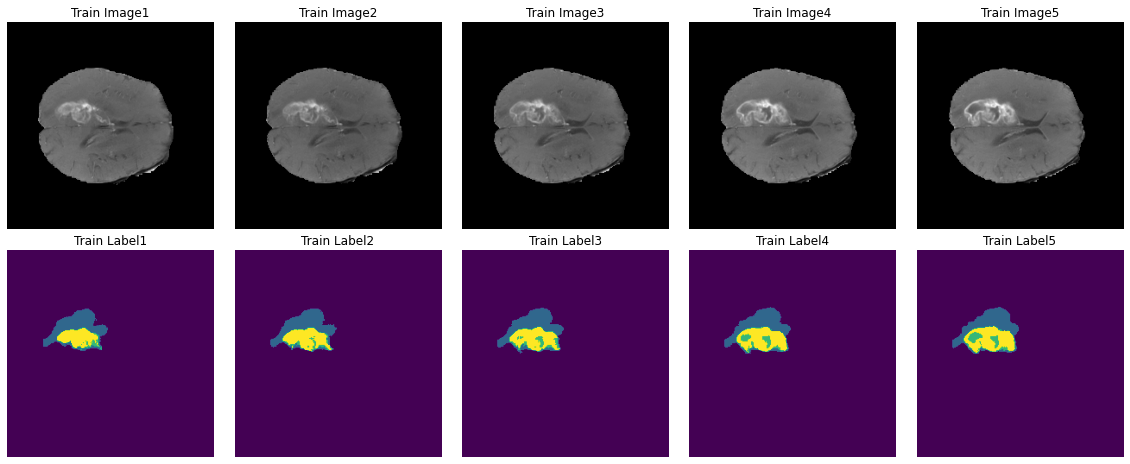

In [51]:
task_name = 'Task001_BrainTumour'
nnunet_raw_data = os.path.join(os.getenv("nnUNet_raw_data_base"), "nnUNet_raw_data")
task_folder_name = os.path.join(nnunet_raw_data, task_name)
train_image_dir = os.path.join(task_folder_name,'imagesTr')
train_label_dir = os.path.join(task_folder_name,'labelsTr')
train_img_name = os.listdir(train_image_dir)[np.random.randint(0,160)]
train_img = np.array(nib.load(os.path.join(train_image_dir,train_img_name)).dataobj)[:,:,70:75]
train_label_name = train_img_name[:train_img_name.find('.nii.gz')-5]+'.nii.gz'
train_label = np.array(nib.load(os.path.join(train_label_dir,train_label_name)).dataobj)[:,:,70:75]

print(train_img.shape,train_label.shape)

max_rows = 2
max_cols = train_img.shape[2]

fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,8))
for idx in range(max_cols):
    axes[0, idx].axis("off") 
    axes[0, idx].set_title('Train Image'+str(idx+1))
    axes[0 ,idx].imshow(train_img[:,:,idx], cmap="gray")
for idx in range(max_cols):    
    axes[1, idx].axis("off")
    axes[1, idx].set_title('Train Label'+str(idx+1))
    axes[1, idx].imshow(train_label[:,:,idx])

plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()

## Training nnU-Net
nnU-Net stores a checkpoint every 50 epochs. If you need to continue a previous training, just add a -c to the training command.

Generic Training Commands:

`nnUNet_train CONFIGURATION TRAINER_CLASS_NAME TASK_NAME_OR_ID FOLD (additional options)`

For 2D: `nnUNet_train 2d nnUNetTrainerV2 TaskXXX_MYTASK FOLD`

For 3D Full resolution: `nnUNet_train 3d_fullres nnUNetTrainerV2 TaskXXX_MYTASK FOLD`

For Cascaded 3D:

First Run lowres: `nnUNet_train 3d_lowres nnUNetTrainerV2 TaskXXX_MYTASK FOLD`

Then Run fullres: `nnUNet_train 3d_cascade_fullres nnUNetTrainerV2CascadeFullRes TaskXXX_MYTASK FOLD`

In [102]:
# train the 3d nnUnet on the Full Resolution with Task 1 and Cross Validation Split 0
!nnUNet_train 3d_fullres nnUNetTrainerV2 1 0

# training the Full Model will take quite a while - therefore it is advised to interrupt the training after some time



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 3d_fullres
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2.nnUNetTrainerV2'>
For that I will be using the following configuration:
num_classes:  3
modalities:  {0: 'FLAIR', 1: 'T1w', 2: 't1gd', 3: 'T2w'}
use_mask_for_norm OrderedDict([(0, True), (1, True), (2, True), (3, True)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT'), (1, 'nonCT'), (2, 'nonCT'), (3, 'nonCT')])
stages...

stage:  0
{'batch_size': 2, 'num_pool_per_axis': [5, 5, 

### Locate Resultfolder and Rename Model (required if Training was interupted)

In [55]:
result_dir = os.path.join(os.getenv("RESULTS_FOLDER"), 'nnUNet_Prediction_Results', "Task001_BrainTumour")
make_if_dont_exist(result_dir)

team_name = 'HK' #make sure to change for your own team name

./nnUNet_Results_Folder/nnUNet_Prediction_Results/Task001_BrainTumour exists.


#### Note: 
this throws an error if already renamed.

In [53]:
# rename model_best.model.pkl to model_final_checkpoint.model.pkl
# rename model_best.model to model_final_checkpoint.model
model_dir = os.path.join(os.getenv("RESULTS_FOLDER"), 'nnUNet', '3d_fullres', 'Task001_BrainTumour', 'nnUNetTrainerV2__nnUNetPlansv2.1', 'fold_0')

os.rename(os.path.join(model_dir, 'model_best.model.pkl'), os.path.join(model_dir, 'model_final_checkpoint.model.pkl'))
os.rename(os.path.join(model_dir, 'model_best.model'), os.path.join(model_dir, 'model_final_checkpoint.model'))

FileNotFoundError: [Errno 2] No such file or directory: './nnUNet_Results_Folder/nnUNet/3d_fullres/Task001_BrainTumour/nnUNetTrainerV2__nnUNetPlansv2.1/fold_0/model_best.model.pkl' -> './nnUNet_Results_Folder/nnUNet/3d_fullres/Task001_BrainTumour/nnUNetTrainerV2__nnUNetPlansv2.1/fold_0/model_final_checkpoint.model.pkl'

## Inference

In [56]:
!nnUNet_predict -i ${nnUNet_raw_data_base}/nnUNet_raw_data/Task001_BrainTumour/imagesTs -o ${RESULTS_FOLDER}/Task001_BrainTumour/predTs -t 1 -tr nnUNetTrainerV2 



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  ./nnUNet_Results_Folder/nnUNet/3d_fullres/Task001_BrainTumour/nnUNetTrainerV2__nnUNetPlansv2.1
This model expects 4 input modalities for each image
Found 34 unique case ids, here are some examples: ['BRATS_321' 'BRATS_429' 'BRATS_458' 'BRATS_425' 'BRATS_429' 'BRATS_250'
 'BRATS_209' 'BRATS_274' 'BRATS_088' 'BRATS_470']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 34
number of cases that still need to be predicted: 34
emptying cuda cache
loading parameters for folds, None
folds is None so we will automatically look for output folders 

(4, 141, 174, 141)
prediction done
preprocessing ./nnUNet_Results_Folder/Task001_BrainTumour/predTs/BRATS_233.nii.gz
force_separate_z: None interpolation order: 1
no resampling necessary
using preprocessor GenericPreprocessor
predicting ./nnUNet_Results_Folder/Task001_BrainTumour/predTs/BRATS_188.nii.gz
debug: mirroring True mirror_axes (0, 1, 2)
step_size: 0.5
do mirror: True
data shape: (4, 139, 172, 134)
patch size: [128 128 128]
steps (x, y, and z): [[0, 11], [0, 44], [0, 6]]
number of tiles: 8
using precomputed Gaussian
before crop: (4, 155, 240, 240) after crop: (4, 135, 176, 134) spacing: [1. 1. 1.] 

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 135, 176, 134)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 135, 176, 134)} 

(4, 135, 176, 134)
prediction done
preprocessing ./nnUNet_Results_Folder/Task001_BrainTumour/predTs

before crop: (4, 155, 240, 240) after crop: (4, 143, 176, 131) spacing: [1. 1. 1.] 

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 143, 176, 131)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 143, 176, 131)} 

(4, 143, 176, 131)
prediction done
force_separate_z: None interpolation order: 1
no resampling necessary
preprocessing ./nnUNet_Results_Folder/Task001_BrainTumour/predTs/BRATS_350.nii.gz
predicting ./nnUNet_Results_Folder/Task001_BrainTumour/predTs/BRATS_274.nii.gz
using preprocessor GenericPreprocessor
debug: mirroring True mirror_axes (0, 1, 2)
step_size: 0.5
do mirror: True
data shape: (4, 137, 171, 141)
patch size: [128 128 128]
steps (x, y, and z): [[0, 9], [0, 43], [0, 13]]
number of tiles: 8
using precomputed Gaussian
before crop: (4, 155, 240, 240) after crop: (4, 136, 162, 122) spacing: [1. 1. 1.] 

no resampling 

(4, 137, 168, 145)
prediction done
preprocessing ./nnUNet_Results_Folder/Task001_BrainTumour/predTs/BRATS_454.nii.gz
using preprocessor GenericPreprocessor
predicting ./nnUNet_Results_Folder/Task001_BrainTumour/predTs/BRATS_378.nii.gz
force_separate_z: None interpolation order: 1
no resampling necessary
debug: mirroring True mirror_axes (0, 1, 2)
step_size: 0.5
do mirror: True
data shape: (4, 144, 167, 139)
patch size: [128 128 128]
steps (x, y, and z): [[0, 16], [0, 39], [0, 11]]
number of tiles: 8
using precomputed Gaussian
before crop: (4, 155, 240, 240) after crop: (4, 138, 170, 144) spacing: [1. 1. 1.] 

no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 138, 170, 144)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 138, 170, 144)} 

(4, 138, 170, 144)
prediction done
force_separate_z: None interpolation order: 1
no resampling nec

## Visualization of Predictions

./data/Task01_BrainTumour/labelsTs/BRATS_470.nii.gz
Test Image Shape:  (240, 240)
True Label Shape: (240, 240)
Predicted Image Shape: (240, 240)


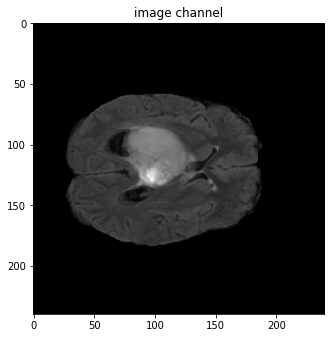

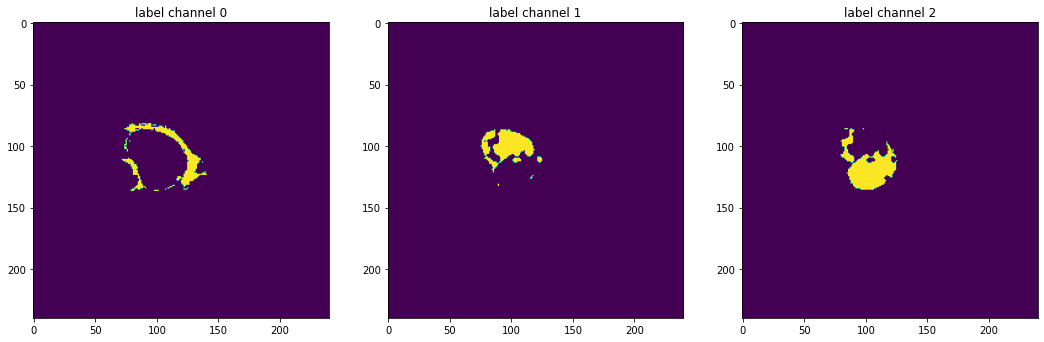

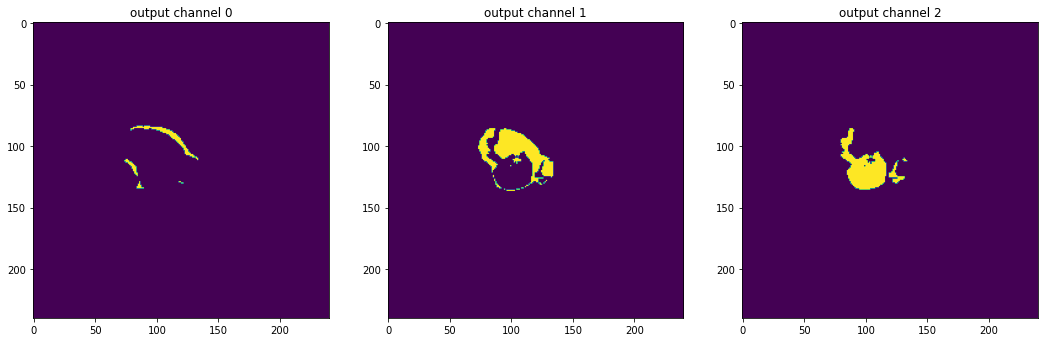

In [91]:
#visualizing the predicted results
# (re-run to see random pick-ups)
# only maximum of first 5 slices are plotted

task_name = "Task001_BrainTumour"
result_dir = os.path.join(os.getenv("RESULTS_FOLDER"), "Task001_BrainTumour", 'predTs')
nnunet_raw_data = os.path.join(os.getenv("nnUNet_raw_data_base"), "nnUNet_raw_data")
task_folder_name = os.path.join(nnunet_raw_data, task_name)
test_dir = os.path.join(task_folder_name,'imagesTs')
test_label_dir = os.path.join(task_folder_name, 'labelsTs')

test_img_name = "BRATS_470_0000.nii.gz"
test_img = np.array(nib.load(os.path.join(test_dir, test_img_name)).dataobj)[:,:,80]
print(os.path.join(os.getenv("RAW_DATA_PATH"), "Task01_BrainTumour", "labelsTs", test_img_name[:9] + ".nii.gz"))
test_label = np.array(nib.load(os.path.join(os.getenv("RAW_DATA_PATH"), "Task01_BrainTumour", "labelsTs", test_img_name[:9] + ".nii.gz")).dataobj)[:,:,80]

predicted_img_name = test_img_name[:test_img_name.find('_0000.nii.gz')]+'.nii.gz'
predicted_label = np.array(nib.load(os.path.join(result_dir,predicted_img_name)).dataobj)[:,:,80]
print('Test Image Shape: ',test_img.shape)
print("True Label Shape:", test_label.shape)
print("Predicted Image Shape:",predicted_label.shape)

plt.figure("image", (24, 6))
plt.subplot(1, 4, 1)
plt.title(f"image channel")
plt.imshow(test_img[:,:], cmap="gray")
plt.show()

# # visualize the 3 channels label corresponding to this image
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(test_label[:,:] == i+1)

plt.show()

# # visualize the 3 channels model output corresponding to this image    
plt.figure("output", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"output channel {i}")
    plt.imshow(predicted_label[:,:] == i+1)

plt.show()

## Evaluation

In [97]:
test = !nnUNet_evaluate_folder -ref ${RAW_DATA_PATH}/Task01_BrainTumour/labelsTs -pred ${RESULTS_FOLDER}/Task001_BrainTumour/predTs -l 1 2 3

In [98]:
result_files = os.listdir(os.path.join(os.getenv("RESULTS_FOLDER"), "Task001_BrainTumour", "predTs"))
for file in os.listdir(os.path.join(os.getenv("RAW_DATA_PATH"), "Task01_BrainTumour", "labelsTs")):
    if(file not in result_files):
        print("File not found: ", file)
        continue

In [99]:
test[9] = test[9].replace('nan', 'np.nan')
result = dict(eval(test[9]))

In [100]:
result["mean"]

OrderedDict([('1',
              OrderedDict([('Accuracy', 0.9979686083438752),
                           ('Dice', 0.7770995605899912),
                           ('False Discovery Rate', 0.17822256382039114),
                           ('False Negative Rate', 0.23489005328770826),
                           ('False Omission Rate', 0.0011581275571754038),
                           ('False Positive Rate', 0.0008881853131606009),
                           ('Jaccard', 0.6514607432321053),
                           ('Negative Predictive Value', 0.9988418724428245),
                           ('Precision', 0.821777436179609),
                           ('Recall', 0.7651099467122918),
                           ('Total Positives Reference', 55430.23529411765),
                           ('Total Positives Test', 53043.617647058825),
                           ('True Negative Rate', 0.9991118146868395)])),
             ('2',
              OrderedDict([('Accuracy', 0.9989859398060301),
    

In [101]:
print("test mean dice: ", np.mean([result["mean"]["1"]["Dice"], result["mean"]["2"]["Dice"], result["mean"]["3"]["Dice"]]))
print("edema:", result["mean"]["1"]["Dice"])
print("non-enhancing tumor:", result["mean"]["2"]["Dice"])
print("enhancing tumour", result["mean"]["3"]["Dice"])

test mean dice:  0.7243056854326676
edema: 0.7770995605899912
non-enhancing tumor: 0.5954676264017715
enhancing tumour 0.8003498693062402
